### Board Game Ranking: Exploratory Data Analysis

#### Context: 

Board games have long been a part of human culture with the historical records dating back as early as 2000 B.C. In recent years, board games have experienced a resurgence in popularity. Tabletop gaming is now a burgeoning industry which had an estimated market of approximately 7.2 billion USD in 2017 and is expected to increase by 4.8 billion USD by 2023. The US card and board game market alone is predicted to increase to 5 billion USD by 2025. Understanding what makes a game popular is important for game developers to determine what kinds of games they should focus on producing.

I've scraped ranking data from BoardGameGeek.com https://www.boardgamegeek.com/browse/boardgame for 19,019 games which will be used in this analysis. This data is current as of 6/12/20.

In [374]:
# import packages and data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.ticker import PercentFormatter
import matplotlib.gridspec as gridspec
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
%matplotlib inline

bgg = pd.read_csv('bgg_clean_impute.csv', index_col=0)
pd.set_option('max_colwidth', 120)

# KNN was used to impute missing values. I'm rounding these columns to remove inconsistencies with age which 
# is recorded as a whole number as well as with player count which must be a whole number
bgg.age = bgg.age.round()
bgg.min_players = bgg.min_players.round()
bgg.max_players = bgg.max_players.round()

In [2]:
# descriptive statistics of the data set
bgg.describe().T

,count,mean,std,min,25%,50%,75%,max
avg_rating,19019.0,6.386327,0.926332,1.050,5.800,6.420,7.000,9.690
geek_rating,19019.0,5.690209,0.370863,3.537,5.511,5.551,5.689,8.573
num_voters,19019.0,813.651349,3331.557546,30.000,55.000,120.000,379.500,94727.000
rank,19019.0,9511.235817,5491.270778,1.000,4755.500,9512.000,14266.500,19021.000
game_id,19019.0,99563.504969,93033.632027,1.000,9856.500,69105.000,180423.000,310100.000
age,19019.0,10.242337,2.710194,1.000,8.000,10.000,12.000,25.000
max_play_time,19019.0,99.528366,1033.539496,1.000,30.000,45.000,90.000,120000.000
max_players,19019.0,5.549293,9.087904,1.000,4.000,4.000,6.000,362.000
min_play_time,19019.0,68.703549,476.215933,1.000,20.000,30.000,60.000,60000.000
min_players,19019.0,2.036490,0.674595,1.000,2.000,2.000,2.000,10.000


In [54]:
bgg.head()

,avg_rating,geek_rating,num_voters,title,full_game_url,rank,game_id,category,mechanic,family,age,max_play_time,max_players,min_play_time,min_players,weight
0,8.83,8.573,35473,Gloomhaven,https://boardgamegeek.com/boardgame/174430/gloomhaven/credits,1,174430,"'Adventure', 'Exploration', 'Fantasy', 'Fighting', 'Miniatures'","'Action Retrieval', 'Campaign / Battle Card Driven', 'Communication Limits', 'Cooperative Game', 'Deck, Bag, and Poo...","'Components: Miniatures', 'Crowdfunding: Kickstarter', 'Dungeon Crawler', 'Game: Gloomhaven', 'Mechanic: Campaign Ga...",12.0,120.0,4.0,60.0,1.0,3.832
1,8.62,8.472,37381,Pandemic Legacy: Season 1,https://boardgamegeek.com/boardgame/161936/pandemic-legacy-season-1/credits,2,161936,"'Environmental', 'Medical'","'Action Points', 'Cooperative Game', 'Hand Management', 'Legacy Game', 'Point to Point Movement', 'Set Collection', ...","'Game: Pandemic', 'Mechanic: Campaign Games', 'Mechanic: Legacy', 'Medical: Diseases'",13.0,60.0,4.0,60.0,2.0,2.830
2,8.64,8.279,13199,Brass: Birmingham,https://boardgamegeek.com/boardgame/224517/brass-birmingham/credits,3,224517,"'Economic', 'Industry / Manufacturing', 'Transportation'","'Connections', 'Hand Management', 'Income', 'Loans', 'Market', 'Network and Route Building', 'Tech Trees / Tech Trac...","'Cities: Birmingham (England)', 'Country: England', 'Crowdfunding: Kickstarter', 'Game: Brass', 'History: Industrial...",14.0,120.0,4.0,60.0,2.0,3.930
3,8.43,8.277,54788,Terraforming Mars,https://boardgamegeek.com/boardgame/167791/terraforming-mars/credits,4,167791,"'Economic', 'Environmental', 'Industry / Manufacturing', 'Science Fiction', 'Space Exploration', 'Territory Building'","'Card Drafting', 'End Game Bonuses', 'Hand Management', 'Hexagon Grid', 'Income', 'Set Collection', 'Solo / Solitair...","'Game: Terraforming Mars', 'Mechanic: Tableau Building', 'Players: Games with Solitaire Rules', 'Series: Future Time...",12.0,120.0,5.0,120.0,1.0,3.236
4,8.47,8.219,20264,Through the Ages: A New Story of Civilization,https://boardgamegeek.com/boardgame/182028/through-ages-new-story-civilization/credits,5,182028,"'Card Game', 'Civilization', 'Economic'","'Action Points', 'Auction/Bidding', 'Auction: Dutch', 'Card Drafting', 'Income'","'Game: Through the Ages', 'Mechanic: Tableau Building'",14.0,120.0,4.0,120.0,2.0,4.395


#### Description of Attributes:

- avg_rating: aggregated ranking of user ratings (1-10)
- geek_rating: BoardGameGeek's proprietary ranking system which uses a weighted avg rating used to determine a game's rank (1-10) 
 - games must have a minimum of 30 user ratings to have a geek rating 
 - games without a geek rating are not included in this data set
- num_voters: number of users who have rated a game
- title: the name of the game
- full_game_url: game page
- rank: absolute ranking of a game based on geek rating
- game_id: unique identifier
- category: a classification for the thematic type of board game
- mechanic: an element or type of gameplay
- family: an attempt to group a game into a broader set of descriptors
- age*: recommened minimum age to play the game
- max_play_time*: the maximum time the game is estimated to complete
- max_players*: maximum number of players the game can support
- min_play_time*: the minimum time the game is estimated to complete
- min_players*: minimum number of players the game can support
- weight: an aggregated measure of complexity as reported by users (1-5)
 
*publisher provided values

### Numerical Attribute Exploration

I first want to investigate the distribution of ratings. Geek rating is what determines a game's placement on the Geek Charts (the scraped pages) and this is based on an altered average rating. As found in the FAQ (https://boardgamegeek.com/wiki/page/BoardGameGeek_FAQ), Bayesian averaging is used to prevent games with few votes from skewing the data. The exact algorithm is unknown, but it is believed by the community that every game receives approximately 100 dummy votes with a 5.5 value.

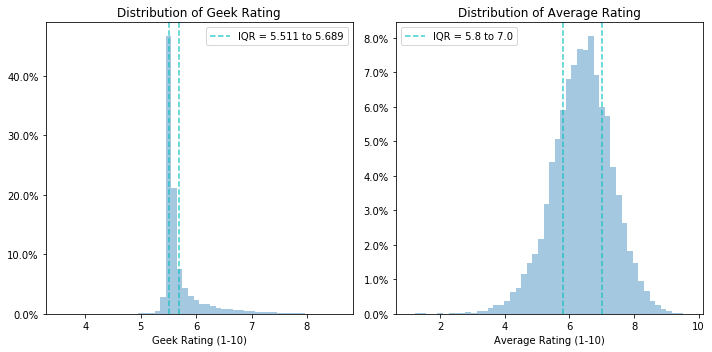

In [4]:
_ = plt.subplots(figsize=(10,5))
_ = plt.subplot(1,2,1)
_ = sns.distplot(bgg.geek_rating, hist_kws={'weights': (np.ones(len(bgg.geek_rating)) / len(bgg.geek_rating))}, kde=False)
_ = plt.axvline(x=bgg.geek_rating.quantile(0.25), label='IQR = 5.511 to 5.689', linestyle='--', color ='c', alpha=.75)
_ = plt.axvline(x=bgg.geek_rating.quantile(0.75), linestyle='--', color ='c', alpha=.75)
_ = plt.xlabel('Geek Rating (1-10)')
_ = plt.title('Distribution of Geek Rating')
_ = plt.legend()
_ = plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

_ = plt.subplot(1,2,2)
_ = sns.distplot(bgg.avg_rating, hist_kws={'weights': (np.ones(len(bgg.avg_rating)) / len(bgg.avg_rating))}, kde=False)
_ = plt.axvline(x=bgg.avg_rating.quantile(0.25), label='IQR = 5.8 to 7.0', linestyle='--', color ='c', alpha=.75)
_ = plt.axvline(x=bgg.avg_rating.quantile(0.75), linestyle='--', color ='c', alpha=.75)
_ = plt.xlabel('Average Rating (1-10)')
_ = plt.title('Distribution of Average Rating')
_ = plt.legend()
_ = plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.tight_layout()

The left chart shows the distribution of the geek rating. In terms of "all-stars" There are 14 games with a geek rating > 8 (0.00736% of games), and 374 with a geek rating > 7 (1.966% of games). Additionally, we can clearly see the Bayesian averaging in effect with the majority of games having a score between 5 and 6 as well as an incredible right skew.

In comparison, avg rating, representing raw user rating, in the right chart shows more distribution among values. Avg rating does not show the same skew and peaks around a rating of 7. This tells us that users tend to rate games positively (>5).

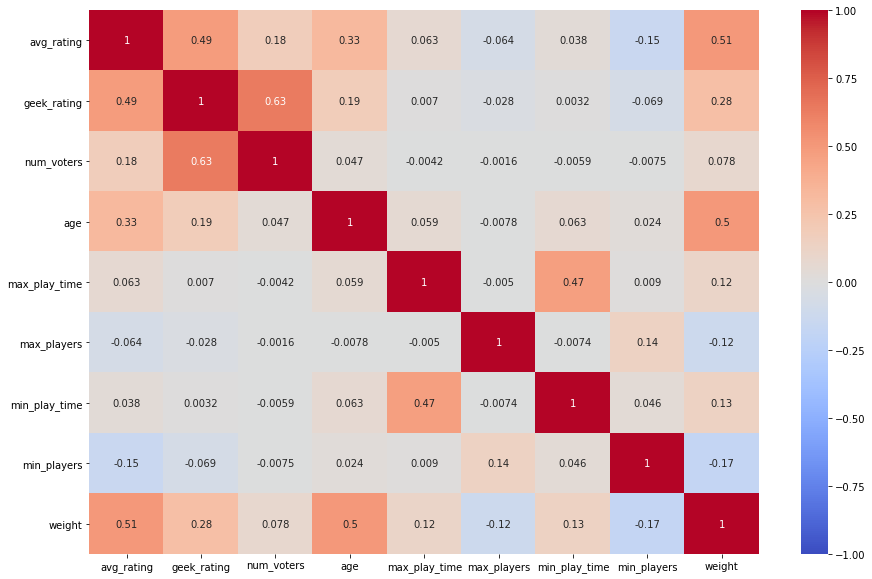

In [5]:
corr = bgg.drop(columns=['rank','game_id']).corr()
fig = plt.subplots(figsize=(15,10))
ax =  sns.heatmap(corr, vmin=-1, vmax=1, annot=True, cmap='coolwarm')

This chart shows the correlation between variables. We can see that the number of votes shows the highest correlation with geek rating (as opposed to avg rating which was expected). In essence, the Bayesian averaging represents a hurdle to overcome and a game needs to be popular by avg rating before it can have a good geek rating.

There are also correlations between age and weight and max play time and min play time.

We should look further at number of voters, age, and weight and their relationships with both geek rating and avg rating.

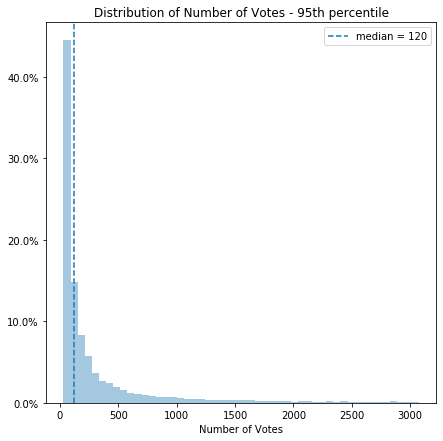

In [6]:
# filtering to only plot the 95th percentile for visualization purposes
bgg_votes = bgg[['num_voters']]
p95 = bgg_votes.quantile(0.95)
bgg_votes95 = bgg_votes[(bgg_votes < p95).any(axis=1)]

_ = plt.figure(figsize=(7,7))
_ = sns.distplot(bgg_votes95, kde=False, hist_kws={'weights' : (np.ones(len(bgg_votes95)) / len(bgg_votes95))})
_ = plt.axvline(x=bgg.num_voters.median(), label='median = 120', linestyle='--')
_ = plt.xlabel('Number of Votes')
_ = plt.title('Distribution of Number of Votes - 95th percentile')
_ = plt.legend()
_ = plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

This shows the distribution of the volume of votes across games. It is important to note that the number of votes includes significant outliers. Incredibly popular games receive a high volume of votes while the average is much lower, so I've only plotted the 95th percentile. While the max number of votes for a game is 94,727, the median is 120. This helps explain why the geek rating rarely deviates from the 5.5 range.

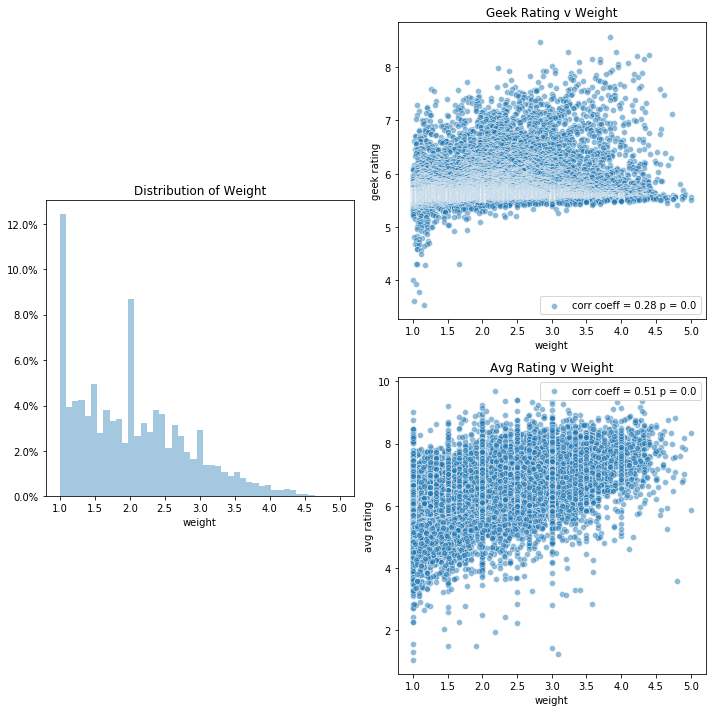

In [7]:
geek_v_weight_coef, geek_v_weight_p = stats.pearsonr(bgg.weight, bgg.geek_rating)
avg_v_weight_coef, avg_v_weight_p = stats.pearsonr(bgg.weight, bgg.avg_rating)


fig = plt.figure(tight_layout=True, figsize=(10,10))
gs = gridspec.GridSpec(8, 2)

ax = fig.add_subplot(gs[2:6, 0])
_ = sns.distplot(bgg.weight, kde=False, hist_kws={'weights' : (np.ones(len(bgg.weight)) / len(bgg.weight))})
_ = plt.title('Distribution of Weight')
_ = plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

ax = fig.add_subplot(gs[0:4, 1])
_ = sns.scatterplot(x='weight', y='geek_rating', data=bgg, alpha=.5, label=str('corr coeff = ' + str(round(geek_v_weight_coef,2)) + ' p = ' + str(geek_v_weight_p)))
_ = plt.ylabel('geek rating')
_ = plt.title('Geek Rating v Weight')

ax = fig.add_subplot(gs[4:8, 1])
_ = sns.scatterplot(x='weight', y='avg_rating', data=bgg, alpha=.5, label=str('corr coeff = ' + str(round(avg_v_weight_coef,2)) + ' p = ' + str(avg_v_weight_p)))
_ = plt.ylabel('avg rating')
_ = plt.title('Avg Rating v Weight')

Here I show the distribution of weight and plot it against geek rating and avg rating. Weight is a user generated number between 1 and 5 representing the complexity of a game. As this is an average, it is biased towards whole and half numbers (e.g. 2.0 or 3.5) due to the volume of games with minimal number of user values recorded. The mean of weight is 2.04 and 75% of all games are below 2.56. While it becomes more sparse at the higher end of weight, we can see a positive correlation between weight and geek rating.

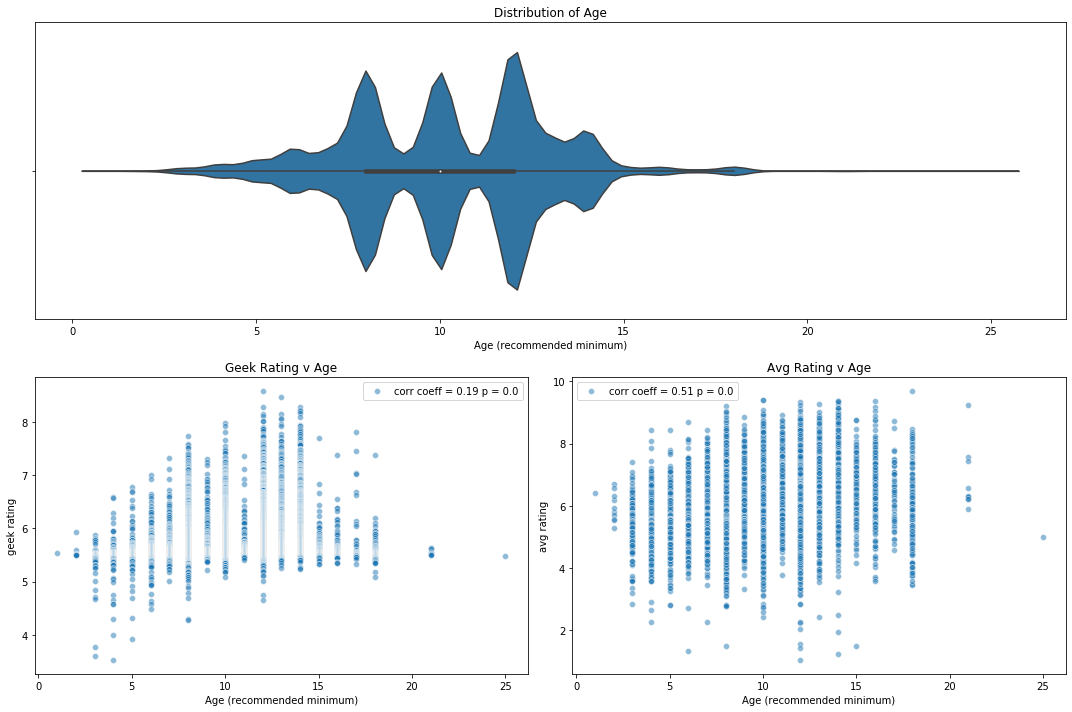

In [8]:
geek_v_age_coef, geek_v_age_p = stats.pearsonr(bgg.age, bgg.geek_rating)
avg_v_age_coef, avg_v_age_p = stats.pearsonr(bgg.age, bgg.avg_rating)

fig = plt.figure(tight_layout=True, figsize=(15,10))
gs = gridspec.GridSpec(2, 2)

ax = fig.add_subplot(gs[0,:])
_ = sns.violinplot('age', data=bgg)
_ = plt.title('Distribution of Age')
_ = plt.xlabel("Age (recommended minimum)")
#_ = plt.savefig('images/Age_Distribution.png')

ax = fig.add_subplot(gs[1,0])
_ = sns.scatterplot(x='age', y='geek_rating', data=bgg, alpha=.5, label=str('corr coeff = ' + str(round(geek_v_age_coef,2)) + ' p = ' + str(round(geek_v_age_p,2))))
_ = plt.ylabel('geek rating')
_ = plt.title('Geek Rating v Age')
_ = plt.xlabel("Age (recommended minimum)")
#_ = plt.savefig('images/Geek_Rating_v_Age.png')


ax = fig.add_subplot(gs[1,1])
_ = sns.scatterplot(x='age', y='avg_rating', data=bgg, alpha=.5, label=str('corr coeff = ' + str(round(avg_v_weight_coef,2)) + ' p = ' + str(avg_v_weight_p)))
_ = plt.ylabel('avg rating')
_ = plt.title('Avg Rating v Age')
_ = plt.xlabel("Age (recommended minimum)")
#_ = plt.savefig('images/Avg_Rating_v_Weight.png')

Mean age is 10, but there are also distribution spikes around 8 and 12-13. Due to age being a discrete variable it is difficult to visualize, but there is correlation with geek rating.

## Label Analysis

The scraped data also includes classifications for each game: Category, Mechanic, and Family. As outlined above:

 - Category is a classification for the thematic type of board game e.g. fantasy or children's game. (There are 83 categories.)
 - Mechanic is an element or type of gameplay. Examples include dice rolling, role play, and trading. (There are 186 mechanics.)
 - Family attempts to group a game into a broader set of descriptors. There is a large variety in family including items such as Ancient: Greece, Crowdfunding: Kickstarter, and Video Game Theme: Pokémon. (There are 2,748 families.)


Each game can be assigned multiple categories, mechanics and families. The lists of category, mechanic and family can be found in these links:
 - https://boardgamegeek.com/browse/boardgamecategory
 - https://boardgamegeek.com/browse/boardgamemechanic
 - https://boardgamegeek.com/browse/boardgamefamily


In [375]:
# creating new dataframes for each label type and geek rating
cat = bgg[['geek_rating']]
csplit = bgg.category.str.split(', ', expand=True)
cat = cat.merge(csplit, left_index=True, right_index=True)

# three mechanics have commas which need to be removed before splitting the string 
bgg['mechanic'] = bgg['mechanic'].str.replace('Deck, Bag, and Pool Building', 'Deck Bag and Pool Building')
bgg['mechanic'] = bgg['mechanic'].str.replace('I Cut, You Choose', 'I Cut You Choose')
bgg['mechanic'] = bgg['mechanic'].str.replace('Worker Placement, Different Worker Types', 'Worker Placement Different Worker Types')
mech = bgg[['geek_rating']]
msplit = bgg.mechanic.str.split(', ', expand=True)
mech = mech.merge(msplit, left_index=True, right_index=True)

fam = bgg[['geek_rating']]
fsplit = bgg.family.str.split(', ', expand=True)
fam = fam.merge(fsplit, left_index=True, right_index=True)

# melting dataframes so that its tidy
cat = cat.melt(id_vars=['geek_rating'], value_name='category').drop(columns='variable').dropna()
mech = mech.melt(id_vars=['geek_rating'], value_name='mechanic').drop(columns='variable').dropna()
fam = fam.melt(id_vars=['geek_rating'], value_name='family').drop(columns='variable').dropna()

# grouping by classification and aggregating by count and mean of geek rating
cat_group = cat.groupby(cat.category).geek_rating.agg(['count','mean'])
cat_group.rename(columns={'mean':'mean_geek_rating'}, inplace=True)
fam_group = fam.groupby(fam.family).geek_rating.agg(['count','mean'])
fam_group.rename(columns={'mean':'mean_geek_rating'}, inplace=True)
mech_group = mech.groupby(mech.mechanic).geek_rating.agg(['count','mean'])
mech_group.rename(columns={'mean':'mean_geek_rating'}, inplace=True)

#### Category

In [172]:
cat_group.sort_values(by='mean_geek_rating', ascending=True).head(5)

,count,mean_geek_rating
category,,
'Trivia',515,5.528363
"""Children's Game""",1427,5.529584
'Memory',477,5.552136
'Electronic',188,5.566516
'Math',129,5.568543


These are the the 5 worst rated categories. In particular, the Children's Games category being a low rating category aligns with the correlation between rating and age. For fun, let's look at the 10 worst games in the data set:

In [173]:
bgg[['title','category','geek_rating','age','weight']].tail(10)

,title,category,geek_rating,age,weight
19009,Operation,"'Action / Dexterity', ""Children's Game"", 'Medical'",4.486,6.0,1.115
19010,LCR,'Dice',4.311,5.0,1.050
19011,Monopoly,"'Economic', 'Negotiation'",4.299,8.0,1.659
19012,Trouble,"""Children's Game"", 'Racing'",4.298,4.0,1.056
19013,The Game of Life,"""Children's Game"", 'Economic'",4.281,8.0,1.177
19014,War,"'Card Game', ""Children's Game""",4.004,4.0,1.000
19015,Bingo,"'Movies / TV / Radio theme', 'Number', 'Party Game'",3.926,5.0,1.048
19016,Candy Land,"""Children's Game"", 'Racing'",3.779,3.0,1.082
19017,Chutes and Ladders,"'Animals', ""Children's Game"", 'Dice', 'Movies / TV / Radio theme'",3.611,3.0,1.021
19018,Tic-Tac-Toe,"'Abstract Strategy', ""Children's Game""",3.537,4.0,1.154


7 of the 10 worst games are in the Children's Games category except Bingo, Monopoly, and LCR (a game that is only about 'winning' dice rolls). We can also see that the weight of these games are around 1, aside from Monopoly, which still only reaches a weight of 1.659. The majority of these games are determined purely by chance and involve little to no decision making.

A standout category however is Abstract Strategy under Tic-Tac-Toe. BoardGameGeek defines Abstract Strategy as:
- theme-less (without storyline)
- built on simple and/or straightforward design and mechanics
- perfect information games
- games that promote one player overtaking their opponent(s)
- little to no elements of luck, chance, or random occurrence

As a category this fits Tic-Tac-Toe, but there are only a handful of moves a player can take. Conversly, this category also includes games such as Chess (6.9 geek rating/3.71 weight) and Go (7.0 geek rating/3.99 weight) both of which have sophisticated strategies to them.

In [174]:
cat_group.sort_values(by='mean_geek_rating').tail(5)

,count,mean_geek_rating
category,,
'Farming',213,5.931338
'Renaissance',238,5.953256
'Industry / Manufacturing',260,5.978542
'City Building',473,5.993662
'Civilization',310,6.047019


And these are the 5 top rated categories. Notably, Farming, Industry/Manufacturing, City Building, and Civilization are all different flavors of a game mechanic commonly known as Resource Management. Game resources are defined as including "tokens, money, land, natural resources, human resources and game points... The game will have rules that determine how players can increase, spend, or exchange their various resources. The skillful management of resources under such rules allows players to influence the outcome of the game." (https://en.wikipedia.org/wiki/Game_mechanics#Resource_management)

In [175]:
bgg[['title','category','geek_rating','age','weight']].head(10)

,title,category,geek_rating,age,weight
0,Gloomhaven,"'Adventure', 'Exploration', 'Fantasy', 'Fighting', 'Miniatures'",8.573,12.0,3.832
1,Pandemic Legacy: Season 1,"'Environmental', 'Medical'",8.472,13.0,2.830
2,Brass: Birmingham,"'Economic', 'Industry / Manufacturing', 'Transportation'",8.279,14.0,3.930
3,Terraforming Mars,"'Economic', 'Environmental', 'Industry / Manufacturing', 'Science Fiction', 'Space Exploration', 'Territory Building'",8.277,12.0,3.236
4,Through the Ages: A New Story of Civilization,"'Card Game', 'Civilization', 'Economic'",8.219,14.0,4.395
5,Twilight Imperium (Fourth Edition),"'Civilization', 'Economic', 'Negotiation', 'Political', 'Science Fiction', 'Space Exploration', 'Wargame'",8.206,14.0,4.220
6,Star Wars: Rebellion,"'Civil War', 'Fighting', 'Miniatures', 'Movies / TV / Radio theme', 'Science Fiction', 'Wargame'",8.158,14.0,3.701
7,Gaia Project,"'Civilization', 'Economic', 'Science Fiction', 'Space Exploration', 'Territory Building'",8.153,12.0,4.332
8,Twilight Struggle,"'Modern Warfare', 'Political', 'Wargame'",8.151,13.0,3.576
9,Great Western Trail,"'American West', 'Animals'",8.104,12.0,3.700


Comparatively, we don't see the same consistency with the top 10 rated games as we did with the worst rated games and the Children's Game category. Half of the top rated games, Gloomhaven, Pandemic Legacy: Season 1, Star Wars: Rebellion, Twilight Struggle, and Great Western Trail, do not fall into the 5 top rated categories.

There are very high and very low rated games across the examined categories, so the takeaway is "not children's games bad, resource management good," but more so the importance of player agency. Games determined by dice rolls or random chance are generally not well received, but games that allow strategy and player choice are. 

A perfect example of this is Scythe, the 11th highest ranked game, which is is an "engine-building game set in an alternate-history 1920s period... Players conquer territory, enlist new recruits, reap resources, gain villagers, build structures, and activate monstrous mechs... Scythe gives players almost complete control over their fate". This was then adapted into a children's game, My Little Scythe, which ranks at a respectable 641, where "players take turns choosing to Move, Seek, or Make. These actions will allow players to increase their friendship and pies, power up their actions, complete quests, learn magic spells, deliver gems and apples to Castle Everfree, and perhaps even engage in a pie fight."

In [176]:
bgg[['title','category','geek_rating','age','weight']][bgg['title'].str.contains("Scythe", na=False)].tail()

,title,category,geek_rating,age,weight
10,Scythe,"'Economic', 'Fighting', 'Science Fiction', 'Territory Building'",8.096,14.0,3.395
640,My Little Scythe,"""Children's Game"", 'Economic', 'Exploration', 'Fantasy', 'Fighting', 'Math'",6.746,8.0,1.983


#### Mechanic

Due to the sheer volume of labels in mechanic, I only want to examine those that are well represented. That is, if only a handful of games in the data set have a particular label, then that label is not representative and can't tell us much on its own about the data set and rating trends of that label. For my purposes here I'll set it to a minimum game count of 5.

In [177]:
mech_group[mech_group['count'] > 5].sort_values(by='mean_geek_rating').head()

,count,mean_geek_rating
mechanic,,
'Roll / Spin and Move',1250,5.522811
'Singing',47,5.542766
'Zone of Control',115,5.597096
'Pattern Recognition',488,5.598094
'Rock-Paper-Scissors',151,5.605026


Here we have the worst 5 rated mechanics.

Roll/Spin and Move is defined as "games where players roll dice or spin spinners and move playing pieces in accordance with the roll. This term is often used derogatorily to imply that there is no thought involved. Roll and move games like Backgammon, however, contain tactical elements." Another instance of random chance negatively influencing the game.

Zone of Control games are where "spaces adjacent to a unit impact the ability of opposing units to move or attack. This is a very common mechanism in wargames."

While Zone of Control is simply an unpopular mechanic (by restricting agency), I think it's fair to say that the others are not mechanics you'd think of as your typical board game.

In [178]:
mech_group[mech_group['count'] > 5].sort_values(by='mean_geek_rating').tail()

,count,mean_geek_rating
mechanic,,
'Force Commitment',7,7.102714
'Action Drafting',18,7.142444
'Turn Order: Role Order',6,7.148500
'Automatic Resource Growth',10,7.308900
'Turn Order: Pass Order',7,7.632571


The top 5 rated mechanics. These appear to be indicative of a more complex rule set.

Force Commitment is a mechanic where players choose how many and how to use their units in battle. Both Scythe and My Little Scythe use this mechanic.

In games with the Turn Order: Pass Order mechanic, players can choose to take an action or pass their turn. This affects player order in subsequent rounds. While in Turn Order: Role Order games all players secretly and simultaneously make a decision on an action, role, or priority they wish, and this determines how the round is played.

Automatic Resource Growth increases your resources over time. This gives players options to consume their resources or save them to gain more. Do you sell or trade for immediate benefits now, or do you hold on until later to amass more?

Lastly, Action Drafting is when "Players select from an assortment of Actions in a shared pool. The available Actions are limited in quantity, and once a player has chosen an Action it may not be chosen again." This adds layers of strategy where players must determine if an action is better to do now or later.

We can see Resource Management shows up again with Action Drafting and Automatic Resource Growth, but also game mechanics that allow players to be strategic in how or when they take their turns. The Turn Order mechanics create opportunities for players to play off of each other and make choices based on other players' tactics or between long and short term goals.

These top mechanics are spares, so let's also take a look if there are common mechanics that also have an above average geek rating.

In [494]:
mech_group[mech_group['count'] > 50].sort_values(by='mean_geek_rating').tail()

,count,mean_geek_rating
mechanic,,
'Solo / Solitaire Game',420,6.164319
'Traitor Game',64,6.219469
'Communication Limits',70,6.241571
'Race',59,6.363559
'End Game Bonuses',54,6.727352


The top mechanics with 50 or more games that have the mechanic. 

Solo / Solitaire Game is a where the game is designed to be or has an option and rules on how to play by yourself. Scythe has this mechanic, but also the number 1 rated game Gloomhaven. Gloomhaven is a game of tactical combat, where players work together to explore and plunder dungeons and ruins in a world that is shaped by the actions and decisions players they take during the game. This world persists between games and is designed to played across many sessions.

Traitor Games are team or co-operative games with a betrayal mechanic. The traitor or traitors are unknown by other players, and is given an alternative condition to win the game by subversion. 

The mechanic Communication Limits prevents players from disseminating certain information to other players. Charades (rank 18,824) first comes to mind as an example, but is another mechanic found in Gloomhaven where players secretly make card selections from their hand that determines their actions during combat. Players are only allowed to speak in generalities about what they plan to do. For example you can say "I'm going to strike this moster pretty hard" but not "I'll do 8 points of damage and knock down the monster immobilizing him for the next round". Restricting communication in this way keeps players immersed in the game, limits overplanning and over communication, and allows for unique and surprising situations to arise.

Not to be confused with NASCAR, the Race mechanic is any sort of game when a player wins be accomplishing a fixed goal. Catan (rank 382) uses this mechanic. In Catan players collect resources and build civilizations. Victory points are gained by performing certain actions such as building a city or creating the largest army and the first player to 10 victory points wins the game.

End Game Bonuses work off of a similar system, but players only gain the victory points at the end of the game. Terraforming Mars (rank 4) uses End Game Bonuses. In this game players take on the role of a corportation and "work together in the terraforming process [on Mars], but compete for getting victory points that are awarded not only for your contribution to the terraforming, but also for advancing human infrastructure throughout the solar system, and doing other commendable things." Once a certain game state is reached Mars is officially terraformed, the game ends, and players are awarded their victory points.

In [495]:
mech_group[mech_group['count'] > 100].sort_values(by='mean_geek_rating').tail()

,count,mean_geek_rating
mechanic,,
'Network and Route Building',505,5.938747
'Variable Phase Order',287,5.963387
'Scenario / Mission / Campaign Game',135,5.970800
'Worker Placement',677,6.011595
'Solo / Solitaire Game',420,6.164319


As we get higher in count we get closer to the data set's mean geek rating, but we still see some stand out mechanics. 

Network and Route Building is defined as "a specialized kind of set collection in which the sets collected represent ties between nodes, often represented as routes between destinations. There are a variety of implementations of this system. 1830: Railways & Robber Barons uses tiles with pre-printed tracks. Empire Builder has players draw lines on the map with crayons or dry-erase markers. 10 Days in Europe has players collect cards representing countries to form a connected trip through Europe."

Another mechanic that affects how a turn is played out is Variable Phase Order. Games with this mechanic have turns that may or may not play in the same way as they did before or will again. An example of this is Puerto Rico (rank 24) where each turn is different than before and depends on every turn is different. During each round of the game players choose a role such as trader or builder and this role provides benefits to the player. The turn order is determined the player who is assigned "Govenor" at the begining of the round as they choose what role they will play in a turn first. The "Govenor" is passed on each turn, so  depending on who is "Govenor" will affect the choices a play makes and their strategy for that round. Puerto Rico also features End Game Bonuses and Action Drafting mechanics mentioned above.

Worker Placement is a flavor of Action Drafting which we saw above and is defined as a mechanc where players are required "to select individual actions from a set of actions available to all players... From a thematic standpoint, the game pieces which players use to draft actions often represent workers of a given trade", hence the name.

Lastly, the most popular mechanic with over 100 games with that label is Scenario / Mission / Campaign Game. These games feature a "system that can be applied to a variety of different maps, starting resources and positions, and even different win and loss conditions. These variable conditions can be assembled into a broader narrative or campaign, or they can be entirely disconnected from one another." Once again we see this in Gloomhaven and this mechanic helps create the feeling of a living and persistent world between games.

#### Family

As with the mechanic labels, I'll only look at families with over 5 games in them.

In [505]:
fam_group[fam_group['count'] > 5].sort_values(by='mean_geek_rating').head(5)

,count,mean_geek_rating
family,,
'TV Series: Dora the Explorer',8,4.533125
'Toys: Lalaloopsy',6,4.831500
'Characters: Hello Kitty',11,4.892636
'Comic Strips: King Features Syndicate',8,4.920500
'Characters: Smurfs',8,4.924375


The worst 5 rated families. All tie ins with children's shows or characters. What else can we learn about this trend? Knowing the popularity I'd expected it to have shown up by now, but let's look at Pokémon, the highest grossing media franchise (https://en.wikipedia.org/wiki/List_of_highest-grossing_media_franchises), for additional insight.

In [502]:
bgg[['title','family','geek_rating']][bgg['family'].str.contains("Pokémon", na=False)]

,title,family,geek_rating
2547,Pokémon Trading Card Game,"'Admin: Game System Entries', 'CCGs (Collectible Card Games)', 'Players: Two Player Only Games', 'Pokémon', 'Theme: ...",5.954
9139,Battle Dome,"'Components: 3-Dimensional (3D)', 'Components: Marbles', 'Pokémon'",5.555
11565,Pokémon Master Trainer II,'Pokémon',5.531
11651,Monster Mash,"'Animals: Mice', 'Brands: Disney', 'Creatures: Monsters', 'Pokémon'",5.530
12140,Monopoly: Pokémon Kanto Edition,"'Monopoly', 'Pokémon', 'Theme: Anime / Manga', 'Video Game Theme: Nintendo'",5.526
13673,Pokémon Trading Figure Game,"'Collectible Miniatures Games', 'Pokémon', 'Theme: Anime / Manga'",5.515
13762,Pokémon Master Trainer,"'Components: Miniatures', 'Pokémon', 'Theme: Anime / Manga'",5.514
15865,Pokémon TCG: Rumble,"'Pokémon', 'Theme: Anime / Manga'",5.498
17488,Pokémon Jr. Adventure Game: Pokémon Emergency!,"'Pokémon', 'Theme: Anime / Manga'",5.477
17643,Pokémon Master Trainer III,"'Pokémon', 'Theme: Anime / Manga'",5.474


What we can see here is, aside from the original Pokémon Trading Card Game, these games do not rate well and all are below the 5.69 average geek rating of the complete data set. In fairness we should also compare this to the Star Wars franchise which is the 5th highest grossing media franchise. With 95 games in the Star Wars family label, this franchise spans the list with Star Wars: Rebillion at rank 7 and a 8.158 geek rating as well as a Star Wars rebranding of The Game of Life at rank 19,016. So, a media franchise does not necessarily mean poorly rated game and other factors are in play, but the trend is there.

In [182]:
fam_group[fam_group['count'] > 5].sort_values(by='mean_geek_rating').tail()

,count,mean_geek_rating
family,,
'Series: Alea Big Box',17,6.912235
'Game: Pandemic',11,6.981545
'Living Card Game',11,7.029636
'Series: Arkham Horror (Fantasy Flight Games)',8,7.129500
'Series: Harvest (Uwe Rosenberg)',12,7.380000


And finally, for the top rated family labels we see various franchises. Series: Alea Big Box, Arkhman Horror, and Harvest as well as Game: Pandemic are families of games thematically and mechanically similar by the same publishers. In constrast, to the low rated families, these are board game franchises, not media franchises.

Additionally, in the top family labels is Living Card Game (LCG). This game family came about in contrast to collectible card games (CCG) first popularized by the game Magic: The Gathering where players duel with a hand created deck of cards of various spells and creatures. Arguably the most important part of the game is collecting the cards and designing your deck. Begining in 1993, new cards are created regularly and there are now nearly 20,000 cards to choose from. LCGs take the deck building, collection, and dueling format of CCGs and reduced the limit of cards that can ever exist. Netrunner: Android is a very popular example of LCG at 49th. It was in production between 2012 and 2018. The publisher produced 1,534 cards and that's all that will ever exist.

In [508]:
bgg[['title','family','geek_rating', 'num_voters']][bgg['family'].str.contains("Crowdfunding: Kickstarter", na=False)]

,title,family,geek_rating,num_voters
0,Gloomhaven,"'Components: Miniatures', 'Crowdfunding: Kickstarter', 'Dungeon Crawler', 'Game: Gloomhaven', 'Mechanic: Campaign Ga...",8.573,35473
2,Brass: Birmingham,"'Cities: Birmingham (England)', 'Country: England', 'Crowdfunding: Kickstarter', 'Game: Brass', 'History: Industrial...",8.279,13199
10,Scythe,"'Components: Miniatures', 'Crowdfunding: Kickstarter', 'Game: Scythe', 'Mechanic: Tableau Building', 'Players: Games...",8.096,50876
12,Spirit Island,"'Components: Miniatures', 'Crowdfunding: Kickstarter', 'Game: Spirit Island', 'Players: Games with Solitaire Rules',...",8.054,19392
20,The 7th Continent,"'Components: Miniatures', 'Crowdfunding: Kickstarter', 'Game: The 7th Continent', 'Mechanic: Campaign Games', 'Playe...",7.921,14386
...,...,...,...,...
18874,What Do You Meme?,"'Crowdfunding: Kickstarter', 'Game: What Do You Meme?', 'Judging Games', 'Theme: Memes'",5.337,1024
18883,Overturn: Rising Sands,"'Admin: Unreleased Games', 'Components: Miniatures', 'Crowdfunding: Kickstarter'",5.322,80
18888,Oneupmanship: Mine's Bigger,'Crowdfunding: Kickstarter',5.315,65
18892,Redshirts,'Crowdfunding: Kickstarter',5.312,351


#### Category & Mechanic

In the last part of the label analysis we'll look at relationships between categories and mechanics.

In [183]:
# creating dummies
cat_dummy = pd.get_dummies(csplit, prefix='cat')
mech_dummy = pd.get_dummies(msplit, prefix='mech')

# game title series
title = bgg.title

# merge title and category then melt into a long dataframe
title_cat = pd.merge(title,csplit,left_index=True, right_index=True)
title_cat_melt = pd.melt(title_cat, id_vars='title', value_name='category')
title_cat_melt.dropna(inplace=True)
title_cat_melt.drop(columns='variable',inplace=True)

# merge title and mechanic then melt into a long dataframe
title_mech = pd.merge(title,msplit,left_index=True, right_index=True)
title_mech_melt = pd.melt(title_mech, id_vars='title', value_name='mechanic')
title_mech_melt.dropna(inplace=True)
title_mech_melt.drop(columns='variable',inplace=True)

# merge both the long dataframes and create a crosstab of them
cat_mech_merge = pd.merge(title_cat_melt, title_mech_melt, how='outer', on='title')
cat_mech_cross = pd.crosstab(cat_mech_merge.category, cat_mech_merge.mechanic)

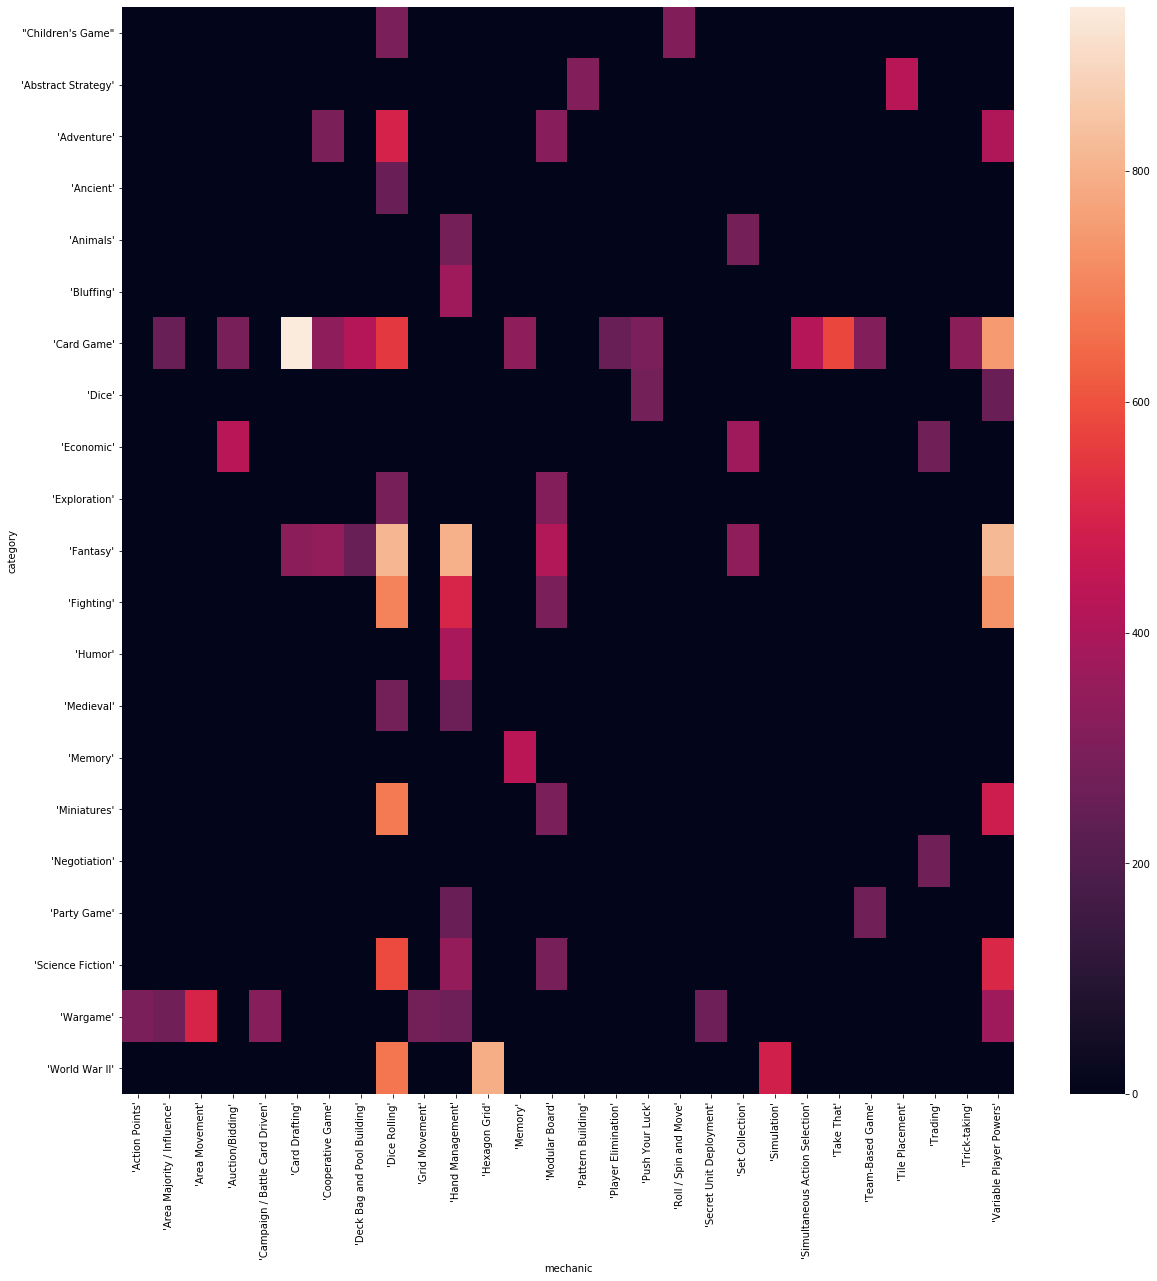

In [301]:
# I capped max value at 1000, this removed the nominal extreme values
# card game/hand management & set collection, Dice/dice rolling and 
# Wargame/dice rolling & Hexagon Grid & Simulation
minval = 250
maxval = 1000
df = cat_mech_cross.where(cat_mech_cross > minval).where(cat_mech_cross < maxval).dropna(axis=1, how='all').dropna(how='all').replace(np.nan,0)
_ = plt.figure(figsize=(20,20))
_ = sns.heatmap(df)

# Section for looking at category and mechanic co-occurences

## Clustering

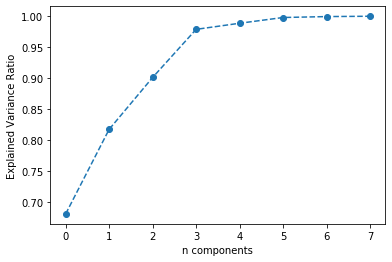

In [407]:
X = bgg.drop(columns=['title', 'full_game_url','rank','game_id','category','mechanic','family','avg_rating'])
#X = pd.concat([X, cat_dummy], axis=1)
# X['play_time']=np.where((X.max_play_time - X.min_play_time) > 0, X.max_play_time - X.min_play_time, X.max_play_time)
# X.drop(columns=['max_play_time', 'min_play_time'], inplace=True)

# scaling
mm_scaler = preprocessing.MinMaxScaler()
mm_scaler.fit(X)
X = mm_scaler.transform(X)

#s_scaler = preprocessing.StandardScaler()
#s_scaler.fit(X)
#X = s_scaler.transform(X)

# fitting to data set 
pca = PCA()
pca.fit(X)
features = range(pca.n_components_)

# plotting explained variance ratio
_ = plt.plot(features, pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
_ = plt.ylabel('Explained Variance Ratio')
_ = plt.xlabel('n components')

In [408]:
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

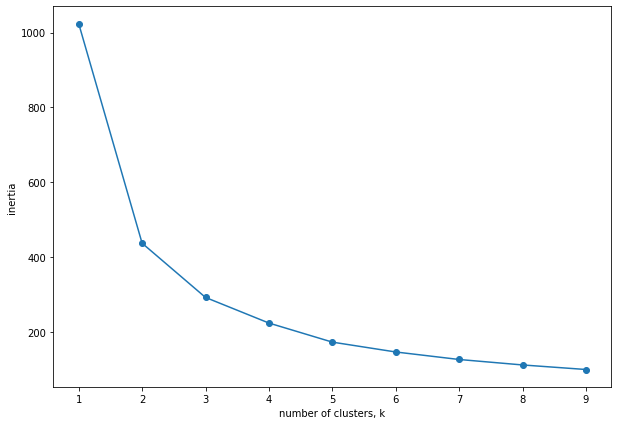

In [409]:
# creating inertia plot to evaluate the number of clusters to use
ks = range(1, 10)
inertias = []

for k in ks:
    # create a KMeans instance with k clusters
    model = KMeans(n_clusters=k, random_state=23)
    
    # fit model to dataframe x
    model.fit(X_pca)
    
    # append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
_ = plt.subplots(figsize=(10,7))
_ = plt.plot(ks, inertias, '-o')
_ = plt.xlabel('number of clusters, k')
_ = plt.ylabel('inertia')
_ = plt.xticks(ks)

In [465]:
kmeans_pca = KMeans(n_clusters=4, random_state=23)
kmeans_pca.fit(X_pca)

bgg_pca_kmeans = pd.concat([bgg, pd.DataFrame(X_pca)], axis=1)
bgg_pca_kmeans.columns.values[-2: ] = ['component_1','component_2']
bgg_pca_kmeans['kmeans_label'] = kmeans_pca.labels_
centroids = kmeans_pca.cluster_centers_

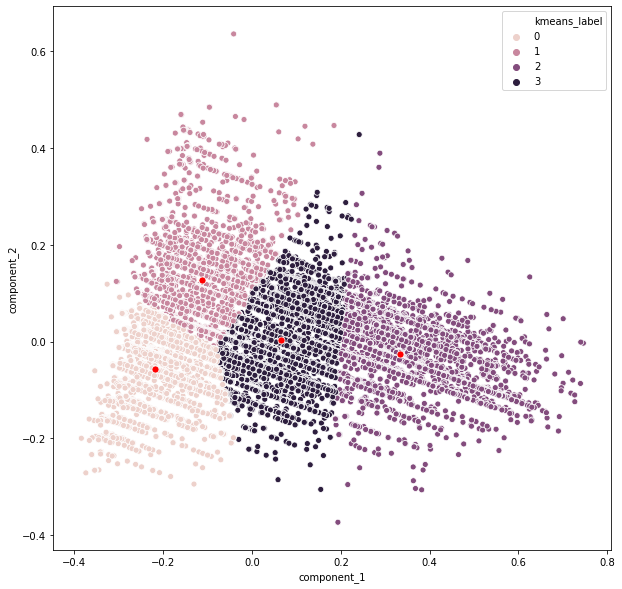

In [442]:
_ = plt.subplots(figsize=(10,10))
_ = sns.scatterplot(data=bgg_pca_kmeans, x='component_1',y='component_2', hue='kmeans_label')
_ = sns.scatterplot(centroids[:, 0], centroids[:, 1], marker='o', s=50, color='r')

In [466]:
dist = cdist(bgg_pca_kmeans[['component_1','component_2']],centroids,'euclidean')
dist = pd.DataFrame(dist, columns=['dist_c0','dist_c1','dist_c2','dist_c3'])
bgg_pca_kmeans = pd.concat([bgg_pca_kmeans, dist], axis=1)

In [475]:
bgg_pca_kmeans[bgg_pca_kmeans.kmeans_label == 0].sort_values('dist_c0').loc[:,'avg_rating':'weight'].head()

,avg_rating,geek_rating,num_voters,title,full_game_url,rank,game_id,category,mechanic,family,age,max_play_time,max_players,min_play_time,min_players,weight
17172,5.25,5.483,90,GoLong Football Dice Game,https://boardgamegeek.com/boardgame/39552/golong-football-dice-game/credits,17175,39552,"'Dice', 'Sports'",'Dice Rolling','Sports: American Football / Gridiron',8.0,60.0,2.0,60.0,1.0,1.223
16653,5.37,5.490,121,Don't Panic!,https://boardgamegeek.com/boardgame/6513/dont-panic/credits,16656,6513,"'Deduction', 'Educational', 'Memory', 'Party Game', 'Real-time', 'Trivia', 'Word Game'",'Memory',NaN,8.0,20.0,8.0,20.0,1.0,1.230
11528,5.64,5.531,459,Colorpop,https://boardgamegeek.com/boardgame/125028/colorpop/credits,11531,125028,"'Abstract Strategy', 'Deduction', 'Puzzle'",'Pattern Building','Players: Games with Solitaire Rules',8.0,20.0,5.0,10.0,1.0,1.225
10434,5.66,5.540,740,Castle Keep,https://boardgamegeek.com/boardgame/17855/castle-keep/credits,10437,17855,"""Children's Game"", 'Medieval'","'Hand Management', 'Tile Placement'",NaN,8.0,20.0,4.0,20.0,1.0,1.215
9565,5.96,5.550,170,Code Cracker,https://boardgamegeek.com/boardgame/27613/code-cracker/credits,9568,27613,"'Dice', 'Puzzle'","'Dice Rolling', 'Push Your Luck'",'Series: Würfelspiele (Ravensburger)',8.0,30.0,6.0,30.0,1.0,1.228


In [476]:
bgg_pca_kmeans[bgg_pca_kmeans.kmeans_label == 1].sort_values('dist_c1').loc[:,'avg_rating':'weight'].head()

,avg_rating,geek_rating,num_voters,title,full_game_url,rank,game_id,category,mechanic,family,age,max_play_time,max_players,min_play_time,min_players,weight
5589,6.67,5.644,237,100 Swords: The Red Dragon's Dungeon,https://boardgamegeek.com/boardgame/178153/100-swords-red-dragons-dungeon/credits,5590,178153,"'Card Game', 'Fantasy'","'Deck Bag and Pool Building', 'Hand Management'","'Crowdfunding: Kickstarter', 'Game: 100 Swords'",13.0,25.0,2.0,25.0,1.0,1.375
1296,6.63,6.332,4309,Ave Caesar,https://boardgamegeek.com/boardgame/494/ave-caesar/credits,1297,494,"'Ancient', 'Racing'","'Hand Management', 'Race', 'Track Movement'","'Ancient: Rome', 'Components: Miniatures'",12.0,30.0,6.0,30.0,2.0,1.361
1745,6.62,6.166,2209,Word on the Street,https://boardgamegeek.com/boardgame/40990/word-street/credits,1746,40990,"'Party Game', 'Word Game'",'Team-Based Game',"'Mensa Select', 'Word Games: Spelling / Letters'",12.0,20.0,10.0,20.0,2.0,1.400
18052,3.90,5.462,31,Gefangen in der Geisterbahn,https://boardgamegeek.com/boardgame/19633/gefangen-der-geisterbahn/credits,18055,19633,"'Horror', 'Movies / TV / Radio theme', 'Novel-based'",NaN,'Creatures: Ghosts',12.0,60.0,5.0,60.0,3.0,1.500
16936,5.06,5.486,43,Sagarian,https://boardgamegeek.com/boardgame/1200/sagarian/credits,16939,1200,"'Memory', 'Trivia'",NaN,'Mensa Select',12.0,60.0,6.0,60.0,3.0,1.500


In [477]:
bgg_pca_kmeans[bgg_pca_kmeans.kmeans_label == 2].sort_values('dist_c2').loc[:,'avg_rating':'weight'].head()

,avg_rating,geek_rating,num_voters,title,full_game_url,rank,game_id,category,mechanic,family,age,max_play_time,max_players,min_play_time,min_players,weight
3354,7.34,5.819,453,Secrets of the Lost Tomb,https://boardgamegeek.com/boardgame/150484/secrets-lost-tomb/credits,3355,150484,"'Adventure', 'Exploration', 'Horror'","'Action Points', 'Cooperative Game', 'Dice Rolling', 'Modular Board', 'Tile Placement', 'Variable Player Powers'","'Crowdfunding: Kickstarter', 'Dungeon Crawler', 'Game: Secrets of the Lost Tomb', 'Theme: Cthulhu Mythos'",13.0,120.0,6.0,120.0,1.0,3.266
1319,7.16,6.324,1598,Legend of the Five Rings,https://boardgamegeek.com/boardgame/1887/legend-five-rings/credits,1320,1887,"'Card Game', 'Collectible Components', 'Fantasy', 'Fighting', 'Medieval'","'Card Drafting', 'Player Elimination', 'Set Collection'","'CCGs (Collectible Card Games)', 'Continents: Asia', 'Legend of the Five Rings'",12.0,45.0,8.0,45.0,2.0,3.293
192,7.60,7.264,8267,1960: The Making of the President,https://boardgamegeek.com/boardgame/27708/1960-making-president/credits,193,27708,'Political',"'Action/Event', 'Area Majority / Influence', 'Campaign / Battle Card Driven', 'Hand Management'","'Country: USA', ""Decades: The 1960's"", 'History: Cold War', 'Players: Two Player Only Games', 'Theme: Elections'",12.0,120.0,2.0,90.0,2.0,3.201
3439,7.59,5.809,341,Machina Arcana,https://boardgamegeek.com/boardgame/144743/machina-arcana/credits,3440,144743,"'Adventure', 'Dice', 'Exploration', 'Fantasy', 'Fighting', 'Horror', 'Mythology', 'Science Fiction'","'Action Points', 'Cooperative Game', 'Dice Rolling', 'Grid Movement', 'Solo / Solitaire Game'","'Crowdfunding: Kickstarter', 'Dungeon Crawler', 'Game: Compact Combat', 'Players: Games with Solitaire Rules', 'Them...",13.0,150.0,4.0,150.0,1.0,3.250
577,7.26,6.802,4200,Vasco da Gama,https://boardgamegeek.com/boardgame/41002/vasco-da-gama/credits,578,41002,"'Nautical', 'Renaissance'","'Action Queue', 'Push Your Luck', 'Tile Placement', 'Worker Placement'","'Country: Portugal', 'History: Age of Discovery', 'Theme: Colonial'",12.0,120.0,4.0,60.0,2.0,3.230


In [479]:
bgg_pca_kmeans[bgg_pca_kmeans.kmeans_label == 3].sort_values('dist_c3').head()

,avg_rating,geek_rating,num_voters,title,full_game_url,rank,game_id,category,mechanic,family,...,min_play_time,min_players,weight,component_1,component_2,kmeans_label,dist_c0,dist_c1,dist_c2,dist_c3
1591,6.72,6.219,2141,Oasis,https://boardgamegeek.com/boardgame/9027/oasis/credits,1592,9027,"'Animals', 'Territory Building'","'Auction/Bidding', 'Enclosure', 'Hand Management', 'Tile Placement'","'Admin: Better Description Needed!', 'Animals: Camels', 'Continents: Asia', 'Country: Mongolia', 'Theme: Deserts'",...,60.0,3.0,2.316,0.067131,0.001443,3,0.291413,0.219598,0.267118,0.002213
923,6.81,6.540,6156,Cleopatra and the Society of Architects,https://boardgamegeek.com/boardgame/22141/cleopatra-and-society-architects/credits,924,22141,'Ancient',"'Auction/Bidding', 'Card Drafting', 'Dice Rolling', 'Enclosure', 'Grid Coverage', 'Hand Management', 'Player Elimina...","'Components: 3-Dimensional (3D)', 'Components: Polyominoes', 'Country: Egypt'",...,60.0,3.0,2.285,0.067862,0.004290,3,0.292711,0.218594,0.266701,0.003225
2586,6.69,5.945,842,Trick of the Rails,https://boardgamegeek.com/boardgame/118497/trick-rails/credits,2587,118497,"'Card Game', 'Trains'","'Stock Holding', 'Trick-taking'",NaN,...,20.0,3.0,2.320,0.061656,0.000746,3,0.285910,0.215527,0.272495,0.003937
3955,6.13,5.753,1007,Mammoth Hunters,https://boardgamegeek.com/boardgame/5767/mammoth-hunters/credits,3956,5767,'Prehistoric','Area Majority / Influence',"'Admin: Better Description Needed!', 'Animals: Mammoths', 'Series: Alea Big Box', 'Sports: Hunting'",...,90.0,3.0,2.346,0.063442,-0.001512,3,0.287215,0.218297,0.270503,0.004368
5755,7.06,5.636,198,Risk: Metal Gear Solid,https://boardgamegeek.com/boardgame/103469/risk-metal-gear-solid/credits,5756,103469,"'Territory Building', 'Video Game Theme', 'Wargame'","'Area Majority / Influence', 'Area Movement', 'Dice Rolling', 'Player Elimination', 'Set Collection'","'Components: Miniatures', 'Game: Risk', 'Series: Risk (Official)'",...,120.0,3.0,2.354,0.062530,-0.002293,3,0.286171,0.218020,0.271341,0.005473
